In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image

In [2]:
# You first need to set you directory structure
# and collect the behavioral files for the localizer and the
# study task separately.  Given that each task will be modeled
# separately treat them separately.
proj_dir = '/home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/'
behav_dir = os.path.join(proj_dir, 'dset', 'sub-021', 'func')
loc_behav_files = sorted(glob(behav_dir + '/*loc*.tsv'))
study_behav_files = sorted(glob(behav_dir + '/*study*.tsv'))

In [4]:
# In this cell I'm going to first work on the localizer task

# Here I am setting up empty dictionary variables that I will
# then fill with keys for the different runs which are saved
# as separate behavioral tab delimited text files
loc_scene_onset_times = {}
loc_face_onset_times = {}

# Here I am iterating over my text files for the localizer task.
# The variable curr_behav_file will be a string variable with
# the full path to the separate runs of the localizer task. idx is a counter
# used for indexing.
for idx, curr_behav_file in enumerate(loc_behav_files):
    # Here I am creating my run keys.  idx is 0 based so I am adding a 1.
    # The variables associated with each key are empty lists.
    loc_scene_onset_times[f'run{idx+1}'] = []
    loc_face_onset_times[f'run{idx+1}'] = []
    
    # I'm using the pandas function read_csv to read in the log files
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')
    
    # I'm creating a temp face and scence onset list variable here because
    # the localizer is a block design task.  I want to convolve a hemodynamic
    # signal over the entire face and scene periods and not separately for
    # each stimulus thus I want to accumulate to onset times for each face/scene
    # image presentation and then grab the first.
    tmp_face_onset = []
    tmp_scene_onset = []
    # iterating over trial_type here...i is counter for indexing
    for i, curr_trial_type in enumerate(curr_behav_data['trial_type']):
        if curr_trial_type == 'face':
            # Here I am appending the onset of the stimulus if the current
            # trial type is a face.
            tmp_face_onset.append(curr_behav_data['onset'][i])
        elif curr_trial_type == 'scence': #note...scence was misspelled originally
            # Here I am appending the onset of the stimulus if the current
            # trial type is a scene.
            tmp_scene_onset.append(curr_behav_data['onset'][i])
        # here I am using the first trial type when it becomes math and the 
        # face onset list variable is 20 elements long (just exited a face block)
        # to assign the first element of the tmp_face_onset list variable to the 
        # dictionary that I created earlier.
        elif curr_trial_type == 'math' and len(tmp_face_onset) == 20:
            loc_face_onset_times[f'run{idx+1}'].append(f'{tmp_face_onset[0]}:25')
            tmp_face_onset = []
        elif curr_trial_type == 'math' and len(tmp_scene_onset) == 20:
            loc_scene_onset_times[f'run{idx+1}'].append(f'{tmp_scene_onset[0]}:25')
            tmp_scene_onset = []
            
# The following code creates a string element that has the square brackets
# removed.  This is important for the following steps below.
loc_scene_run1_data = ", ".join(map(str, loc_scene_onset_times['run1']))
loc_scene_run2_data = ", ".join(map(str, loc_scene_onset_times['run2']))
loc_face_run1_data = ", ".join(map(str, loc_face_onset_times['run1']))
loc_face_run2_data = ", ".join(map(str, loc_face_onset_times['run2']))

# Here I am defining the sink directory where I would like to save the timing files
evs_sink_dir = os.path.join(proj_dir, 'derivatives', 'first_lvl', 'sub-021', 'evs')
# I check to see if the directory exists.  If it doesn't I create it.
if not os.path.isdir(evs_sink_dir):
    os.makedirs(evs_sink_dir)
    
# below I am defining the file names for the localizer (loc) face and scene evs.
# each run is captured on a separate line with the multiple onsets within a run
# captured on a single line
loc_scene_evs_file = 'loc_scene_evs.1D'
with open(os.path.join(evs_sink_dir, loc_scene_evs_file), 'wt') as fp:
    fp.writelines([f'{loc_scene_run1_data}\n'])
    fp.writelines([f'{loc_scene_run2_data}\n'])
loc_face_evs_file = 'loc_face_evs.1D'
with open(os.path.join(evs_sink_dir, loc_face_evs_file), 'wt') as fp:
    fp.writelines([f'{loc_face_run1_data}\n'])
    fp.writelines([f'{loc_face_run2_data}\n'])

In [5]:
# Similar to above I am creating empty dictionary variables
# for each of the events that I am interested in.
# I will then insert run keys to separate the timing files 
# for the events of interest and their specific runs.
task_fixb4_c_cond_onset_times = {}
task_fixb4_ic_cond_onset_times = {}
task_remain_events_onset_times = {}
task_facefixb4_bl_onset_times = {}
task_scenefixb4_bl_onset_times = {}

# Here I am iterating over the study behavior files.  There should be
# 4 of them.
for idx, curr_behav_file in enumerate(study_behav_files):
    # I set the run key for each condition of interest
    task_fixb4_c_cond_onset_times[f'run{idx+1}'] = []
    task_fixb4_ic_cond_onset_times[f'run{idx+1}'] = []
    task_remain_events_onset_times[f'run{idx+1}'] = []
    task_facefixb4_bl_onset_times[f'run{idx+1}'] = []
    task_scenefixb4_bl_onset_times[f'run{idx+1}'] = []
    
    # I read in the current study run behavioral file
    curr_behav_data = pd.read_csv(curr_behav_file, sep='\t')
    
    # I iterate now over the contents of the run specific data.
    # I am specifically iterating over trial_type
    for i, curr_trial_type in enumerate(curr_behav_data['trial_type']):
        # I am evaluating whether or not the current trail type was a 
        # fixed association that had a conditional trial that followed with a face
        # or a scene
        if 'face' in curr_trial_type or 'scene' in curr_trial_type:
            # if it was either of those grab that onset
            tmp_fix_onset = curr_behav_data['onset'][i]
            # if this is not our first trial (i = counter > 0) - remember python is 0-based
            if i > 0:
                # evaluate whether or not the LAST TRIAL (i-1) was a scene or face fix trial
                # grab the current onset time and assign it to the remaining events.
                # In the analysis that I am interested in pursuing I want to separate these
                # trials from trials where the fix face and scence trials are followed either
                # by a conditional trial or by a baseline trial
                # I THINK THERE IS A BUG HERE...SEEMING TO ONLY ASSIGN THESE AT THE END OF RUNS
                # DEBUG PLEASE
                if 'face' in curr_behav_data['trial_type'][i-1] or 'scene' in curr_behav_data['trial_type'][i-1]:
                    task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
        # Here I am evaluating whether or not the current trial type is a conditional trial 
        # that was responded to correctly
        elif curr_trial_type == 'COND' and curr_behav_data['acc'][i] == 1.0:
            task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
            # I am then evaluating wheter or not the LAST TRIAL (i - 1)...was a fix scence or face
            # trial and then appending that temp onset to fill in  
            if 'face' in curr_behav_data['trial_type'][i-1] or 'scene' in curr_behav_data['trial_type'][i-1]:
                task_fixb4_c_cond_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
        # I do the same for conditional trials that were incorrect.  Trying to separate
        # fix trials that preceded correct from incorrect conditional trials
        elif curr_trial_type == 'COND' and curr_behav_data['acc'][i] == 0.0:
            task_remain_events_onset_times[f'run{idx+1}'].append(curr_behav_data['onset'][i])
            if 'face' in curr_behav_data['trial_type'][i-1] or 'scene' in curr_behav_data['trial_type'][i-1]:
                task_fixb4_ic_cond_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
        # Now I am doing the same thing for trials that precede the perceptual baseline trials
        # These trials will be used for the MVPA anlaysis that is planned.
        # TO DO:  NEED TO SEPARATE THESE FOR SCENCE AND FACE RATHER THAN COMBINE
        elif curr_trial_type == 'baseline' and 'face' in curr_behav_data['trial_type'][i-1]:
                task_facefixb4_bl_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
        elif curr_trial_type == 'baseline' and 'scene' in curr_behav_data['trial_type'][i-1]:
                task_scenefixb4_bl_onset_times[f'run{idx+1}'].append(tmp_fix_onset)
            
# Given that we're setting things up to analyze in AFNI
# you can't have runs that don't have any events in them....or
# you can but you can't have an empty row...thus here I am checking
# to see if the runs are empty and if they are adding a filler (-1)
for curr_run in ['run1', 'run2', 'run3', 'run4']:
    if len(task_fixb4_c_cond_onset_times[curr_run]) == 0:
        task_fixb4_c_cond_onset_times[curr_run].append(-1)
    if len(task_fixb4_ic_cond_onset_times[curr_run]) == 0:
        task_fixb4_ic_cond_onset_times[curr_run].append(-1)
    if len(task_remain_events_onset_times[curr_run]) == 0:
        task_remain_events_onset_times[curr_run].append(-1)
    if len(task_facefixb4_bl_onset_times[curr_run]) == 0:
        task_facefixb4_bl_onset_times[curr_run].append(-1)
    if len(task_scenefixb4_bl_onset_times[curr_run]) == 0:
        task_scenefixb4_bl_onset_times[curr_run].append(-1)

# Reformatting as before to save as a text file with no square brackets
task_fixb4_c_cond_r1 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run1']))
task_fixb4_c_cond_r2 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run2']))
task_fixb4_c_cond_r3 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run3']))
task_fixb4_c_cond_r4 = ", ".join(map(str, task_fixb4_c_cond_onset_times['run4']))

task_fixb4_ic_cond_r1 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run1']))
task_fixb4_ic_cond_r2 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run2']))
task_fixb4_ic_cond_r3 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run3']))
task_fixb4_ic_cond_r4 = ", ".join(map(str, task_fixb4_ic_cond_onset_times['run4']))

task_remain_evs_cond_r1 = ", ".join(map(str, task_remain_events_onset_times['run1']))
task_remain_evs_cond_r2 = ", ".join(map(str, task_remain_events_onset_times['run2']))
task_remain_evs_cond_r3 = ", ".join(map(str, task_remain_events_onset_times['run3']))
task_remain_evs_cond_r4 = ", ".join(map(str, task_remain_events_onset_times['run4']))

task_facefixb4_bl_cond_r1 = ", ".join(map(str, task_facefixb4_bl_onset_times['run1']))
task_facefixb4_bl_cond_r2 = ", ".join(map(str, task_facefixb4_bl_onset_times['run2']))
task_facefixb4_bl_cond_r3 = ", ".join(map(str, task_facefixb4_bl_onset_times['run3']))
task_facefixb4_bl_cond_r4 = ", ".join(map(str, task_facefixb4_bl_onset_times['run4']))

task_scenefixb4_bl_cond_r1 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run1']))
task_scenefixb4_bl_cond_r2 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run2']))
task_scenefixb4_bl_cond_r3 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run3']))
task_scenefixb4_bl_cond_r4 = ", ".join(map(str, task_scenefixb4_bl_onset_times['run4']))

# Creating and checking to see if the directory exists
evs_sink_dir = os.path.join(proj_dir, 'derivatives', 'first_lvl', 'sub-021', 'evs')
if not os.path.isdir(evs_sink_dir):
    os.makedirs(evs_sink_dir)

# creating my separate ev files with runs written to each line
task_fixb4_c_cond_evs_file = 'fix_b4_c_cond_evs.1D'
with open(os.path.join(evs_sink_dir, task_fixb4_c_cond_evs_file), 'wt') as fp:
    fp.writelines([f'{task_fixb4_c_cond_r1}\n'])
    fp.writelines([f'{task_fixb4_c_cond_r2}\n'])
    fp.writelines([f'{task_fixb4_c_cond_r3}\n'])
    fp.writelines([f'{task_fixb4_c_cond_r4}\n'])
        
task_fixb4_ic_cond_evs_file = 'fix_b4_ic_cond_evs.1D'
with open(os.path.join(evs_sink_dir, task_fixb4_ic_cond_evs_file), 'wt') as fp:
    fp.writelines([f'{task_fixb4_ic_cond_r1}\n'])
    fp.writelines([f'{task_fixb4_ic_cond_r2}\n'])
    fp.writelines([f'{task_fixb4_ic_cond_r3}\n'])
    fp.writelines([f'{task_fixb4_ic_cond_r4}\n'])
    
task_facefixb4_bl_evs_file = 'facefix_b4_bl_evs.1D'
with open(os.path.join(evs_sink_dir, task_facefixb4_bl_evs_file), 'wt') as fp:
    fp.writelines([f'{task_facefixb4_bl_cond_r1}\n'])
    fp.writelines([f'{task_facefixb4_bl_cond_r2}\n'])
    fp.writelines([f'{task_facefixb4_bl_cond_r3}\n'])
    fp.writelines([f'{task_facefixb4_bl_cond_r4}\n'])
    
task_scenefixb4_bl_evs_file = 'scenefix_b4_bl_evs.1D'
with open(os.path.join(evs_sink_dir, task_scenefixb4_bl_evs_file), 'wt') as fp:
    fp.writelines([f'{task_scenefixb4_bl_cond_r1}\n'])
    fp.writelines([f'{task_scenefixb4_bl_cond_r2}\n'])
    fp.writelines([f'{task_scenefixb4_bl_cond_r3}\n'])
    fp.writelines([f'{task_scenefixb4_bl_cond_r4}\n'])

task_remain_evs_file = 'events_remain_evs.1D'
with open(os.path.join(evs_sink_dir, task_remain_evs_file), 'wt') as fp:
    fp.writelines([f'{task_remain_evs_cond_r1}\n'])
    fp.writelines([f'{task_remain_evs_cond_r2}\n'])
    fp.writelines([f'{task_remain_evs_cond_r3}\n'])
    fp.writelines([f'{task_remain_evs_cond_r4}\n'])


In [6]:
# This cell is required to run the following 3dDeconvolve calls in the subsequent cells
# Here I am collecting the motion related regressor files that were created for each run
# separately, concatenating them and saving the output.

proj_dir = '/home/data/madlab/Mattfeld_PSB6351/mattfeld_2020'
motion_dir = '/derivatives/preproc/sub-021/motion'

loc_motion_files = sorted(glob(proj_dir + motion_dir + '/*loc*bold.1D'))
loc_mot_dict = {}
for mot_i, curr_loc_motion_file in enumerate(loc_motion_files):
    loc_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_loc_motion_file)
    
allruns_loc_motion_data = np.concatenate((loc_mot_dict['run1'], loc_mot_dict['run2']))
np.savetxt(proj_dir + motion_dir + '/allruns_loc_mot_data.1D', allruns_loc_motion_data)

task_motion_files = sorted(glob(proj_dir + motion_dir + '/*study*bold.1D'))
task_mot_dict = {}
for mot_i, curr_task_motion_file in enumerate(task_motion_files):
    task_mot_dict[f'run{mot_i + 1}'] = np.genfromtxt(curr_task_motion_file)
    
allruns_task_motion_data = np.concatenate((task_mot_dict['run1'], task_mot_dict['run2'],
                                           task_mot_dict['run3'], task_mot_dict['run4']))
np.savetxt(proj_dir + motion_dir + '/allruns_task_mot_data.1D', allruns_task_motion_data)



In [8]:
%%bash
# Given that we are running this with no data (see -nodata flag) we can run a quick bash
# command in the cell by using line above.  The matrices that are created and image
# will be created in the directory where this jupyter notebook is running. In my case.
# /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/code

3dDeconvolve -nodata 608 1.76 \
-concat '1D: 0 304' \
-ortvec /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/preproc/sub-021/motion/allruns_loc_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 2 \
-stim_times_AM1 1 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/loc_face_evs.1D "dmBLOCK(1)" -stim_label 1 faces \
-stim_times_AM1 2 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/loc_scene_evs.1D "dmBLOCK(1)" -stim_label 2 scenes \
-x1D X.loc.xmat.1D -xjpeg X.loc.jpg



Stimulus: faces 
  h[ 0] norm. std. dev. =   0.1158

Stimulus: scenes 
  h[ 0] norm. std. dev. =   0.1188

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.8307

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   1.0796

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   1.4136

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5051

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.7278

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.3525


++ '-stim_times_AM1 1 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/loc_face_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/loc_face_evs.1D'
++ '-stim_times_AM1 2 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/loc_scene_evs.1D' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/loc_scene_evs.1D'
++ 3dDeconvolve extending num_stimts from 2 to 8 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=608 time po

In [9]:
%%bash

3dDeconvolve -nodata 1420 1.76 \
-concat '1D: 0 355 710 1065' \
-ortvec /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/preproc/sub-021/motion/allruns_task_mot_data.1D motion \
-polort A \
-local_times \
-num_stimts 5 \
-stim_times 1 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/fix_b4_c_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 1 fx_b4_c_cond \
-stim_times 2 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/fix_b4_ic_cond_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 2 fx_b4_ic_cond \
-stim_times 3 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/events_remain_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 3 all_remain \
-stim_times 4 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/facefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 4 facefx_b4_bl \
-stim_times 5 /home/data/madlab/Mattfeld_PSB6351/mattfeld_2020/derivatives/first_lvl/sub-021/evs/scenefix_b4_bl_evs.1D "TWOGAMpw(4,5,0.2,12,7)" -stim_label 5 scenefx_b4_bl \
-x1D X.task.xmat.1D -xjpeg X.task.jpg



Stimulus: fx_b4_c_cond 
  h[ 0] norm. std. dev. =   0.1013

Stimulus: fx_b4_ic_cond 
  h[ 0] norm. std. dev. =   0.1728

Stimulus: all_remain 
  h[ 0] norm. std. dev. =   0.0690

Stimulus: facefx_b4_bl 
  h[ 0] norm. std. dev. =   0.1271

Stimulus: scenefx_b4_bl 
  h[ 0] norm. std. dev. =   0.1265

Stimulus: motion[0] 
  h[ 0] norm. std. dev. =   1.1945

Stimulus: motion[1] 
  h[ 0] norm. std. dev. =   0.8885

Stimulus: motion[2] 
  h[ 0] norm. std. dev. =   0.8179

Stimulus: motion[3] 
  h[ 0] norm. std. dev. =   0.5316

Stimulus: motion[4] 
  h[ 0] norm. std. dev. =   1.0832

Stimulus: motion[5] 
  h[ 0] norm. std. dev. =   0.2544


++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ GAM conversion: peak=4 fwhm=5 -> p=3.62495 q=1.10346
++ GAM conversion: peak=12 fwhm=7 -> p=16.3728 q=0.732921
++ 3dDeconvolve extending num_stimts from 5 to 11 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.10 (Aug  4 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.76 seconds for -stim_times and -nodata
++ using NT=1420 time points for -nodata
++ Imaging duration=624.8 s; Automatic polort=5
++ -stim_times using TR=1.76 s for stimulus timing conversion
++ -stim_times using TR=1.76 s for any -iresp output da

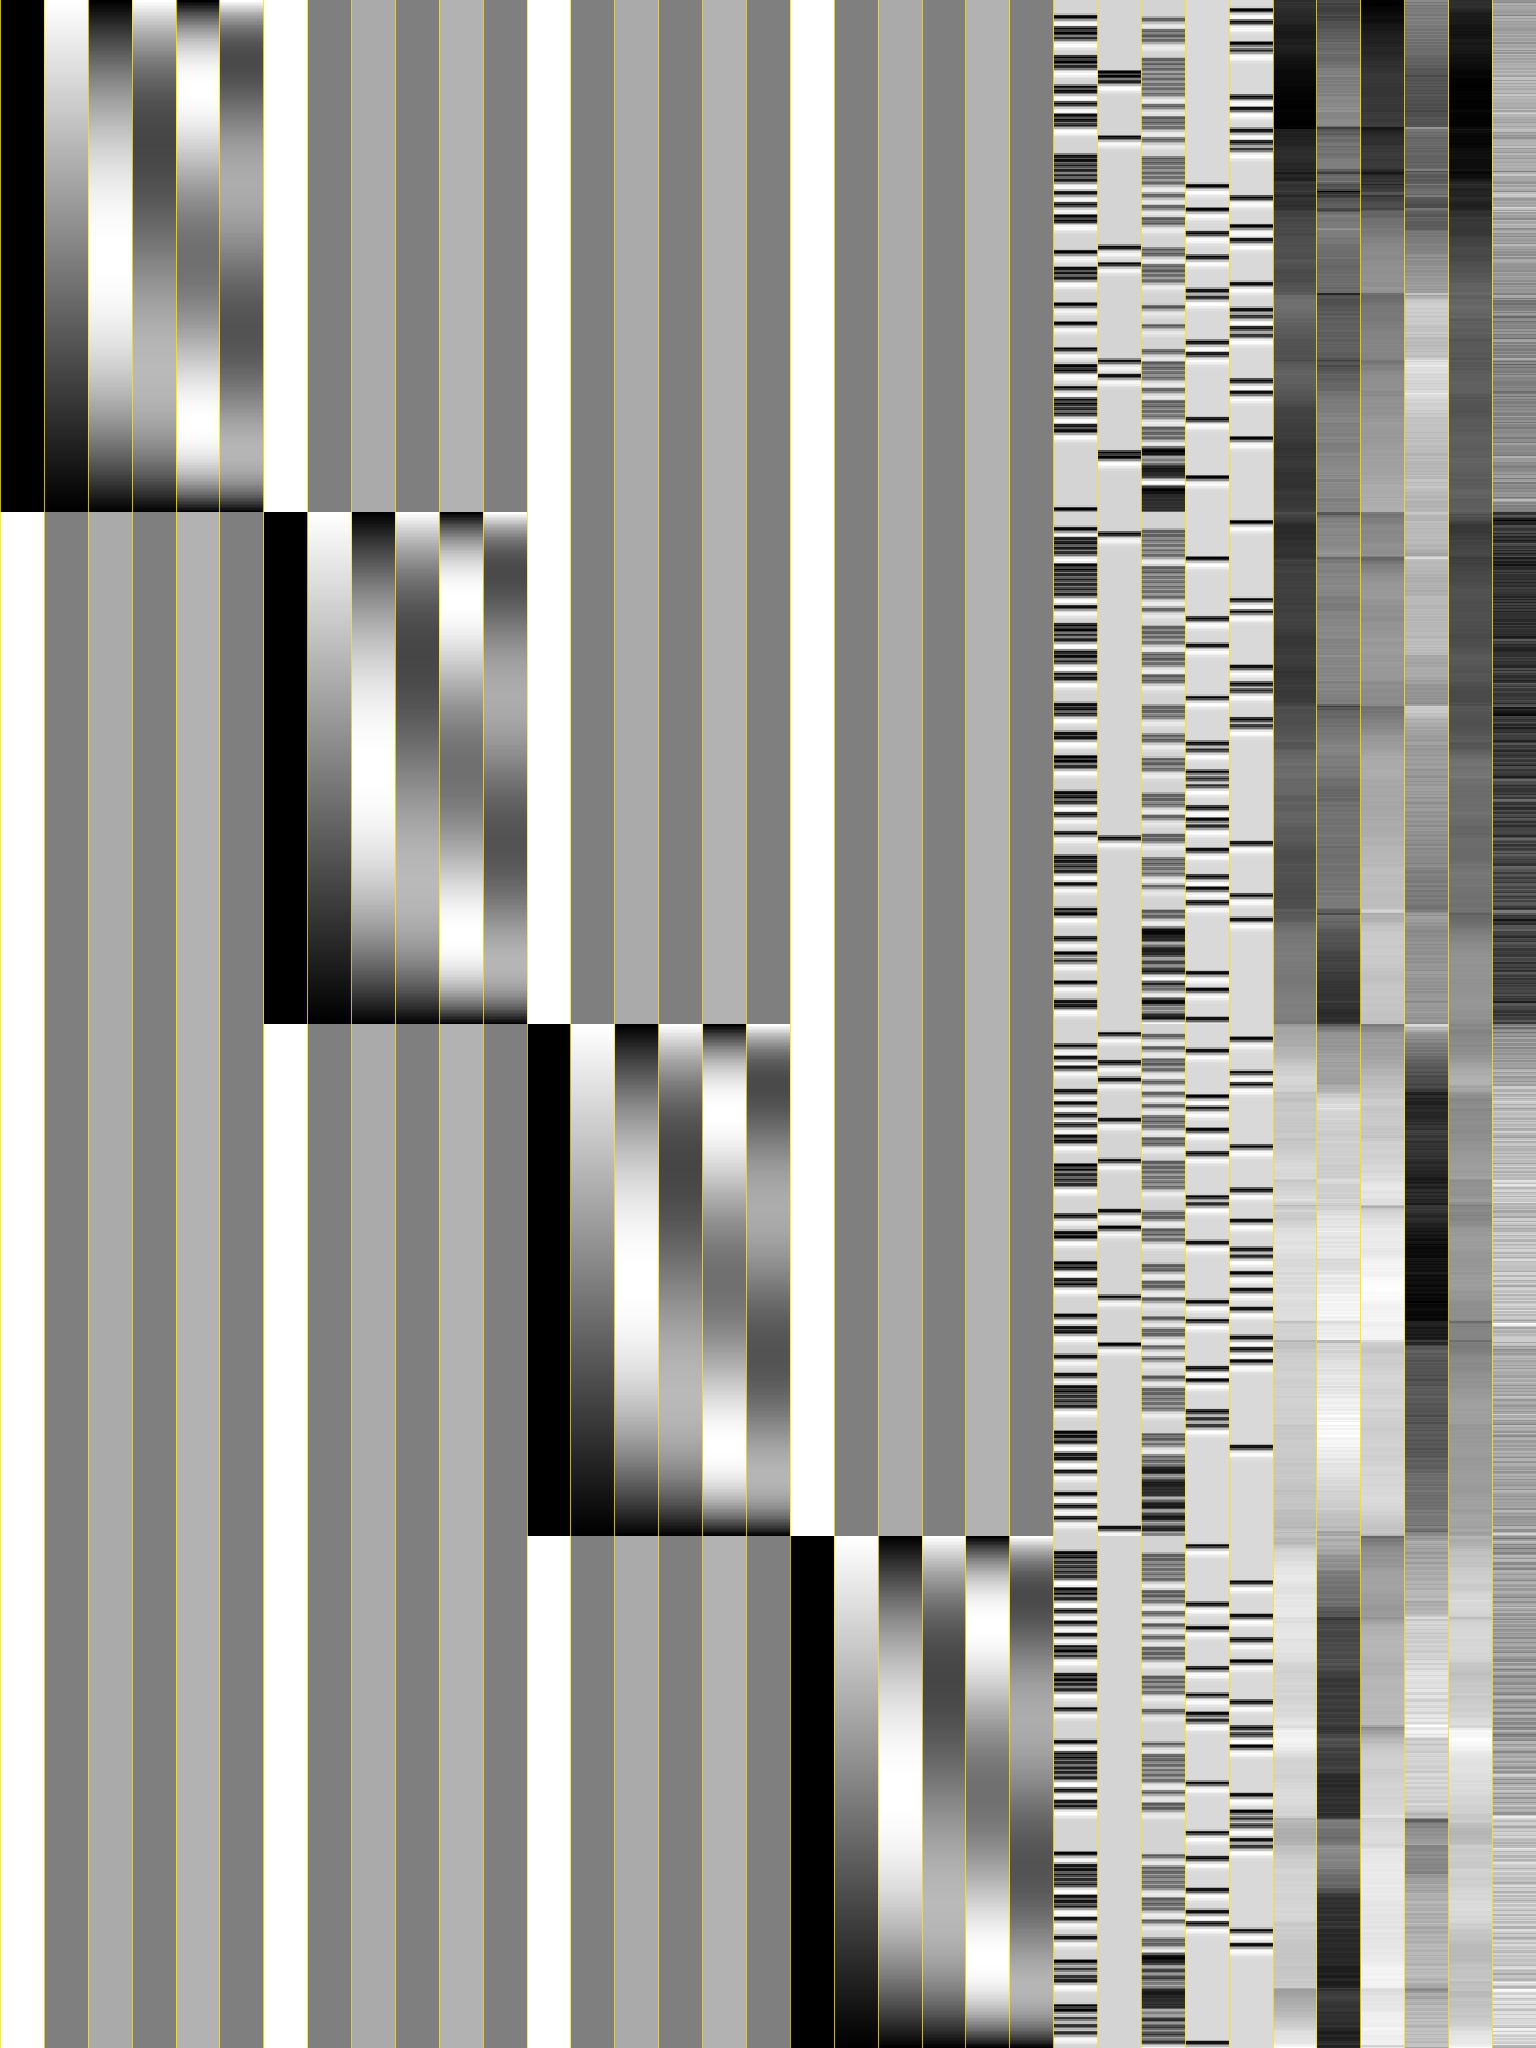

In [10]:
im_task = Image.open(os.path.join(os.getcwd(), 'X.task.jpg'))
im_task

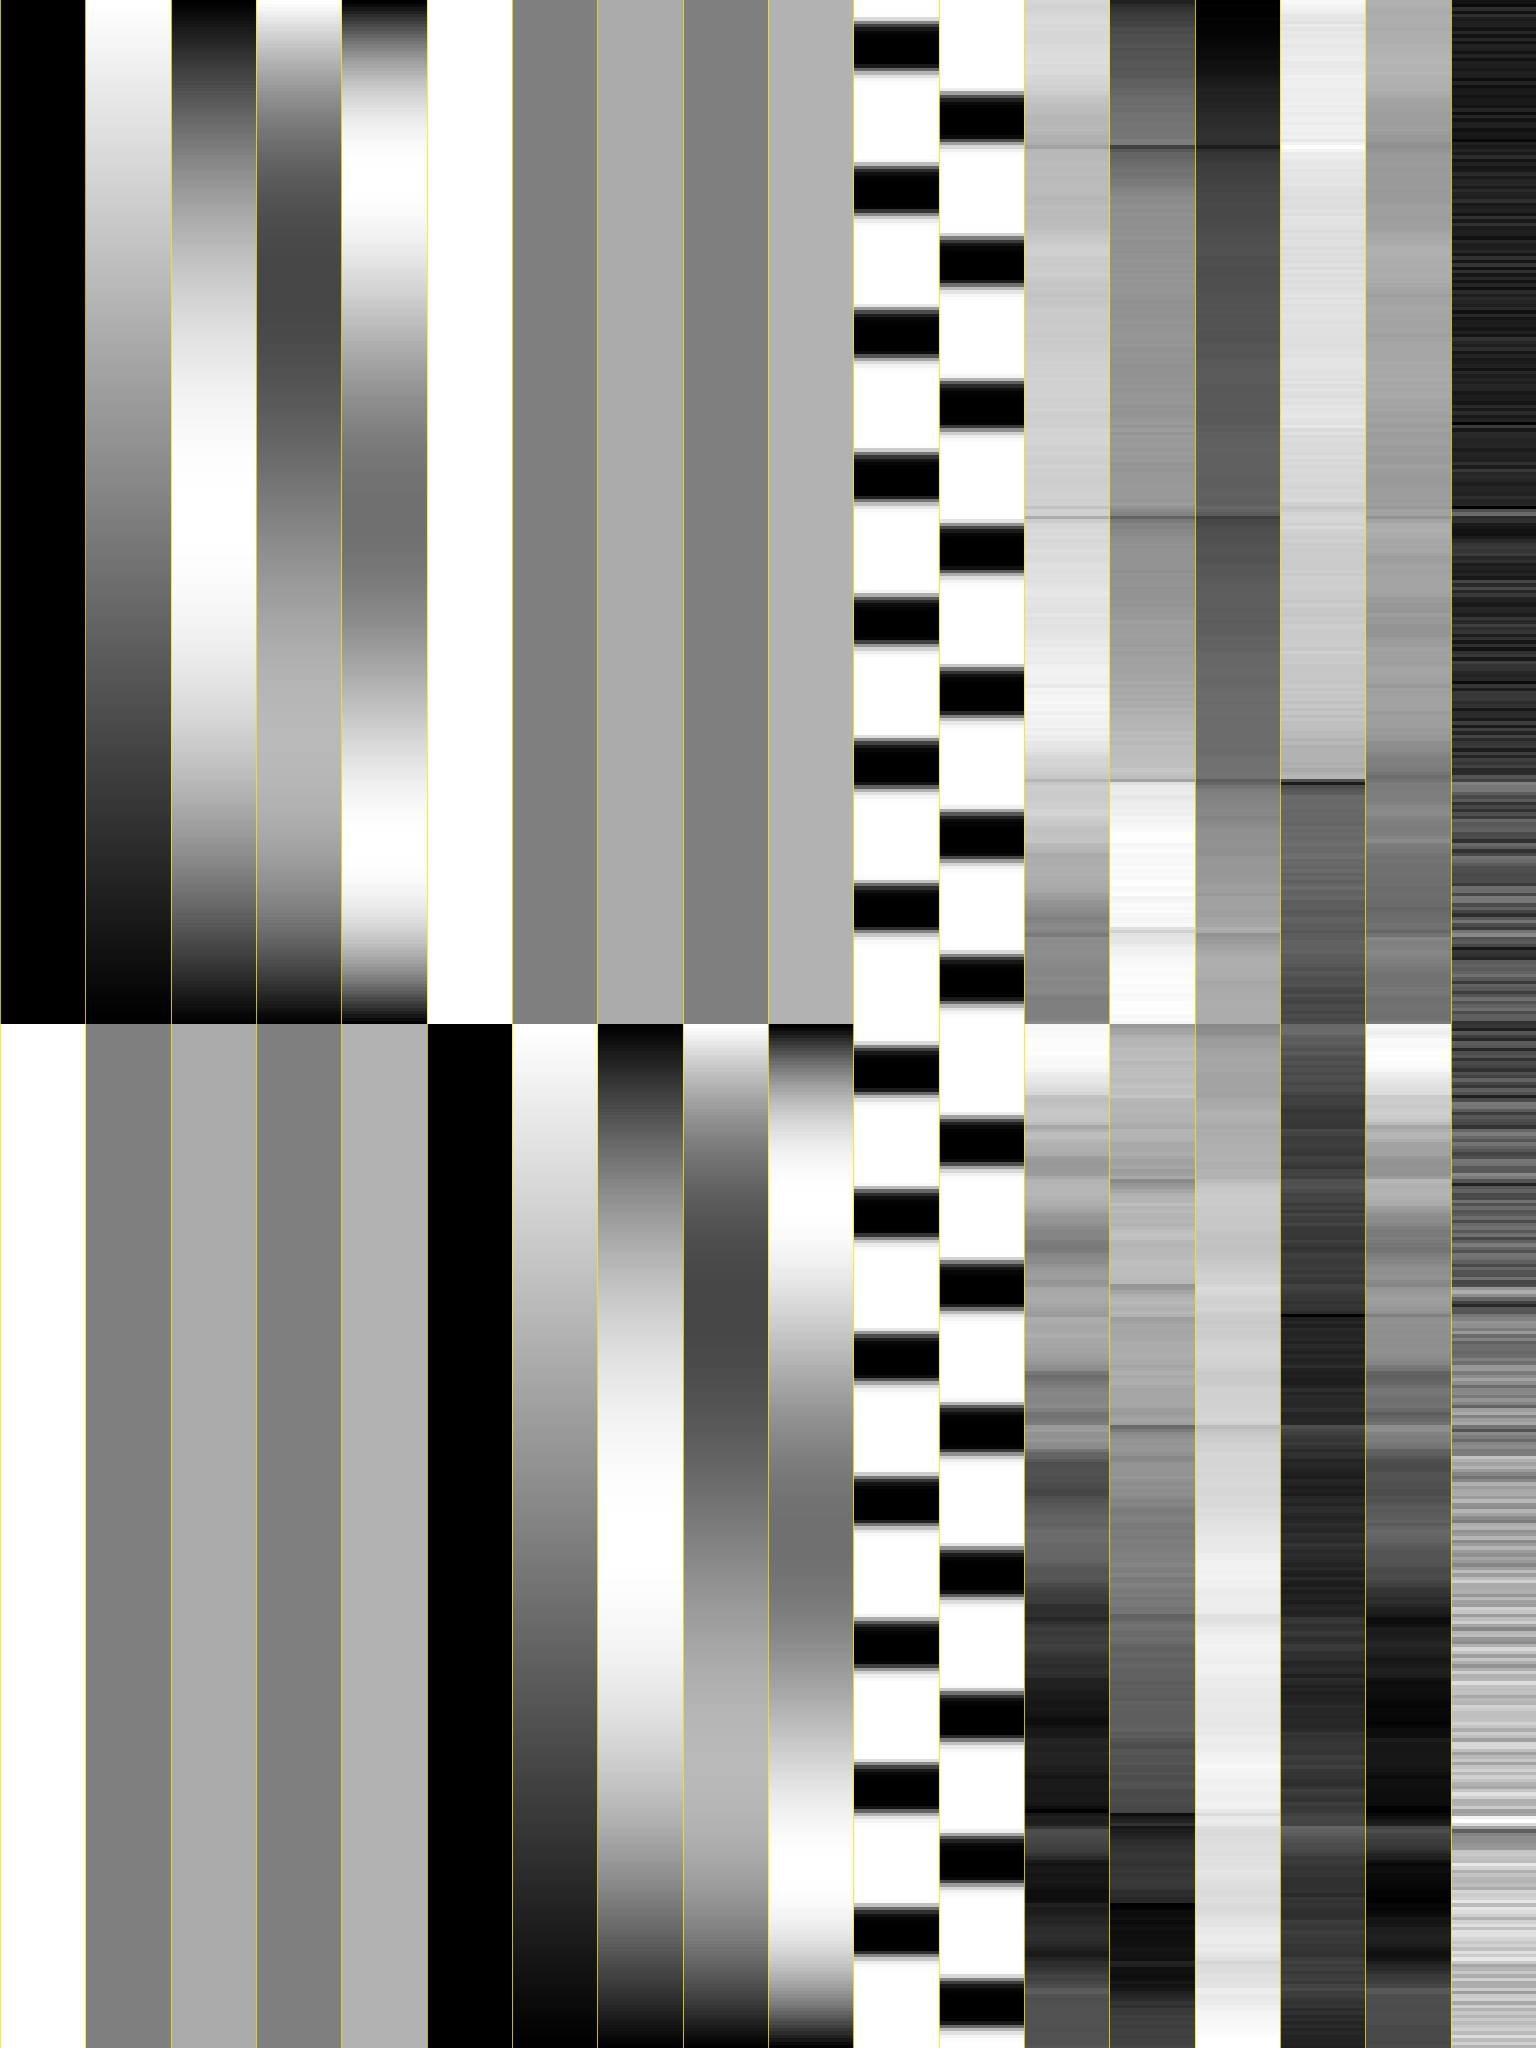

In [11]:
im_loc = Image.open(os.path.join(os.getcwd(), 'X.loc.jpg'))
im_loc